In [4]:
# Scrappper (Data Scrapping from Banggood.com

import time
import sys
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

CATEGORY_URLS = {
    "Toys Hobbies and Robot": "https://www.banggood.com/Wholesale-RC-Vehicles-ca-7007.html?bid=21070102&from=nav",
    "Fitness Wellness": "https://www.banggood.com/Wholesale-Fitness-Wellness-ca-6016.html?bid=80730",
    "Commercial Lighting": "https://www.banggood.com/Wholesale-Commercial-Lighting-ca-14124.html?bid=21071005&from=nav",
    "Chargers & Cables": "https://www.banggood.com/Wholesale-Chargers-and-Cables-ca-1052.html?bid=21070604&from=nav",
    "Kitchen Appliances": "https://www.banggood.com/Wholesale-Kitchen-Appliances-ca-9065.html?bid=21070804&from=nav",
    "Jewelry,Watches & Accessories": "https://www.banggood.com/Wholesale-Jewelry,Watches-and-Accessories-ca-8001.html?bid=21071105&from=nav",

}

def check_chrome_driver():
    try:
        driver = webdriver.Chrome()
        driver.quit()
        print("[INFO] ChromeDriver installed and accessible.")
    except Exception as e:
        print("[ERROR] ChromeDriver NOT found or compatible. Please install ChromeDriver and add it to your PATH.")
        print("Download: https://sites.google.com/chromium.org/driver/")
        print("--- Full Error Message ---")
        print(str(e))
        sys.exit(1)

def scrape_banggood_category(cat_name, url, max_pages=None):
    options = Options()
    options.add_argument("--headless=new")  # new headless mode (Chrome 109+)
    driver = webdriver.Chrome(options=options)

    products = []
    page = 1
    while True:
        print(f"\n[INFO] Scraping {cat_name} | page {page}")
        driver.get(f"{url}?page={page}")
        time.sleep(3)

        product_cards = driver.find_elements(By.CSS_SELECTOR, "div.p-wrap")
        print(f"[INFO] Found {len(product_cards)} products on page {page}")

        if not product_cards:
            print("[INFO] No more products found, ending this category.")
            break

        for idx, card in enumerate(product_cards, start=1):
            try:
                name_elem = card.find_element(By.CSS_SELECTOR, "a.title")
                name = name_elem.get_attribute("title") or name_elem.text
                prod_url = name_elem.get_attribute("href")

                price_elem = card.find_element(By.CSS_SELECTOR, "span.price-box > span.price")
                price = price_elem.text  # e.g. "US$23.99"

                # reviews: often like "123 Reviews"
                try:
                    reviews_elem = card.find_element(By.CSS_SELECTOR, "a.review")
                    reviews = reviews_elem.text
                except:
                    reviews = None

                # rating: sometimes inside .prd-sold-review .review-text
                try:
                    rating_elem = card.find_element(By.CSS_SELECTOR, "div.prd-sold-review .review-text")
                    rating = rating_elem.text
                except:
                    rating = None

                products.append({
                    "category_name": cat_name,
                    "category_url": url,
                    "product_name": name,
                    "price_raw": price,
                    "rating_raw": rating,
                    "reviews_raw": reviews,
                    "product_url": prod_url
                })

                print(f"[DATA] {cat_name} | Name: {name} | Price: {price} | Rating: {rating} | Reviews: {reviews}")
            except Exception as e:
                print(f"[WARN] Error extracting product #{idx} on page {page}: {e}")

        if max_pages and page >= max_pages:
            print(f"[INFO] Max page limit {max_pages} reached for {cat_name}.")
            break

        # try to detect next button
        try:
            next_btn = driver.find_element(By.CSS_SELECTOR, "a.page-next")
            if "disabled" in next_btn.get_attribute("class"):
                print("[INFO] Last page reached for this category.")
                break
        except:
            print("[INFO] Next button not found, ending this category.")
            break

        page += 1

    driver.quit()
    print(f"[INFO] Category '{cat_name}' completed. Total products scraped: {len(products)}\n")
    return products

if __name__ == "__main__":
    check_chrome_driver()
    all_products = []
    # max_pages = 3  # Optional: use while testing
    for cat_name, url in CATEGORY_URLS.items():
        all_products.extend(scrape_banggood_category(cat_name, url))  # , max_pages

    df = pd.DataFrame(all_products)
    df.to_csv("banggood_scraped_products.csv", index=False)
    print(f"[INFO] CSV saved: banggood_scraped_products.csv with {len(df)} products!")


[INFO] ChromeDriver installed and accessible.

[INFO] Scraping Toys Hobbies and Robot | page 1
[INFO] Found 30 products on page 1
[DATA] Toys Hobbies and Robot | Name: JIABAILE 4301/02/03/04 RTR 1/43 2.4G 4WD Drift RC Car Mini Race LED Light Optional Gyro Radio Control High-Speed Motor On-Road Racing Vehicle Model Boys Gifts Outdoor Toys | Price: US$23.99 | Rating: 4.82 | Reviews: 253 reviews
[DATA] Toys Hobbies and Robot | Name: JJRC C8812 RTR 2.4G RC Car Tank High Speed Drift Track Off-Road Truck Full Proportional LED Light 360° Rotate Vehicles Models Toys | Price: US$48.99 | Rating: 4.92 | Reviews: 88 reviews
[DATA] Toys Hobbies and Robot | Name: MJX HYPER GO 16208 16209 1/16 Brushless High Speed RC Car Vehicle Models 45km/h | Price: US$93.99 | Rating: 4.85 | Reviews: 698 reviews
[DATA] Toys Hobbies and Robot | Name: THE LINK G2067 RTR 1/16 2.4G RC Car Tank High Speed RIPSAW EV3-F4 Drift Tracked Off-Road Truck Full Proportional LED Light 360° Rotate Vehicles Models Toy | Price: US$5

In [40]:
# Step 2
import pandas as pd
import numpy as np
import re

df = pd.read_csv("banggood_scraped_products.csv")
df.head(100)


,category_name,category_url,product_name,price_raw,rating_raw,reviews_raw,product_url
0,Toys Hobbies and Robot,https://www.banggood.com/Wholesale-RC-Vehicles...,JIABAILE 4301/02/03/04 RTR 1/43 2.4G 4WD Drift...,US$23.99,4.82,253 reviews,https://www.banggood.com/JIABAILE-4301-or-02-o...
1,Toys Hobbies and Robot,https://www.banggood.com/Wholesale-RC-Vehicles...,JJRC C8812 RTR 2.4G RC Car Tank High Speed Dri...,US$48.99,4.92,88 reviews,https://www.banggood.com/JJRC-C8812-RTR-2_4G-R...
2,Toys Hobbies and Robot,https://www.banggood.com/Wholesale-RC-Vehicles...,MJX HYPER GO 16208 16209 1/16 Brushless High S...,US$93.99,4.85,698 reviews,https://www.banggood.com/MJX-HYPER-GO-16208-16...
3,Toys Hobbies and Robot,https://www.banggood.com/Wholesale-RC-Vehicles...,THE LINK G2067 RTR 1/16 2.4G RC Car Tank High ...,US$50.99,5.00,9 reviews,https://www.banggood.com/THE-LINK-G2067-RTR-1-...
4,Toys Hobbies and Robot,https://www.banggood.com/Wholesale-RC-Vehicles...,SG PINECONE FOREST SG686 2.4G 1/72 Rc Boat Pow...,US$30.79,4.92,53 reviews,https://www.banggood.com/SG-PINECONE-FOREST-SG...
...,...,...,...,...,...,...,...
95,Kitchen Appliances,https://www.banggood.com/Wholesale-Kitchen-App...,Comfook Electric Vacuum Sealer Dry/Wet Food Se...,US$24.39,5.00,13 reviews,https://www.banggood.com/Comfook-Electric-Vacu...
96,Kitchen Appliances,https://www.banggood.com/Wholesale-Kitchen-App...,BlitzHome® SV2209 1100W Sous Vide Cooker APP C...,US$64.99,4.78,152 reviews,https://www.banggood.com/BlitzHome-SV2209-1100...
97,Kitchen Appliances,https://www.banggood.com/Wholesale-Kitchen-App...,XIAOMI Mijia Electronic Scale Precision Electr...,US$27.53,5.00,1 review,https://www.banggood.com/XIAOMI-Mijia-Electron...
98,Kitchen Appliances,https://www.banggood.com/Wholesale-Kitchen-App...,Comfook Mini Portable Hand-Powered Espresso Co...,US$21.96,4.80,5 reviews,https://www.banggood.com/Comfook-Mini-Portable...


In [41]:
# Clean price

def parse_price(text):
    if pd.isna(text):
        return np.nan
    text = str(text)
    # remove currency symbols and commas
    cleaned = text.replace("US$", "").replace("$", "").replace(",", "").strip()
    # find a number like 12 or 12.34
    m = re.search(r"\d+(\.\d+)?", cleaned)
    if not m:
        return np.nan
    return float(m.group(0))

df["price"] = df["price_raw"].apply(parse_price)


In [42]:
# Clean reviews

def parse_reviews(text):
    if pd.isna(text):
        return np.nan
    text = str(text)
    m = re.search(r"\d+", text)
    if not m:
        return np.nan
    return int(m.group(0))

df["reviews_count"] = df["reviews_raw"].apply(parse_reviews)


In [45]:
# Clean rating

def parse_rating(text):
    if pd.isna(text):
        return np.nan
    text = str(text)
    m = re.search(r"\d+(\.\d+)?", text)
    if not m:
        return np.nan
    return float(m.group(0))

df["rating"] = df["rating_raw"].apply(parse_rating)


In [46]:
# value_score (higher rating, lower price → better)

df["value_score"] = df["rating"] / df["price"]

In [ ]:
# popularity_score (more reviews * higher rating)

df["popularity_score"] = df["reviews_count"] * df["rating"]

In [47]:
# save the cleaned file

df.to_csv("banggood_cleaned_products.csv", index=False)
print("Saved cleaned data to banggood_cleaned_products.csv")
df.head()


Saved cleaned data to banggood_cleaned_products.csv


,category_name,category_url,product_name,price_raw,rating_raw,reviews_raw,product_url,price,reviews_count,rating,value_score
0,Toys Hobbies and Robot,https://www.banggood.com/Wholesale-RC-Vehicles...,JIABAILE 4301/02/03/04 RTR 1/43 2.4G 4WD Drift...,US$23.99,4.82,253 reviews,https://www.banggood.com/JIABAILE-4301-or-02-o...,23.99,253,4.82,0.200917
1,Toys Hobbies and Robot,https://www.banggood.com/Wholesale-RC-Vehicles...,JJRC C8812 RTR 2.4G RC Car Tank High Speed Dri...,US$48.99,4.92,88 reviews,https://www.banggood.com/JJRC-C8812-RTR-2_4G-R...,48.99,88,4.92,0.100429
2,Toys Hobbies and Robot,https://www.banggood.com/Wholesale-RC-Vehicles...,MJX HYPER GO 16208 16209 1/16 Brushless High S...,US$93.99,4.85,698 reviews,https://www.banggood.com/MJX-HYPER-GO-16208-16...,93.99,698,4.85,0.051601
3,Toys Hobbies and Robot,https://www.banggood.com/Wholesale-RC-Vehicles...,THE LINK G2067 RTR 1/16 2.4G RC Car Tank High ...,US$50.99,5.00,9 reviews,https://www.banggood.com/THE-LINK-G2067-RTR-1-...,50.99,9,5.00,0.098058
4,Toys Hobbies and Robot,https://www.banggood.com/Wholesale-RC-Vehicles...,SG PINECONE FOREST SG686 2.4G 1/72 Rc Boat Pow...,US$30.79,4.92,53 reviews,https://www.banggood.com/SG-PINECONE-FOREST-SG...,30.79,53,4.92,0.159792


In [14]:
#1 GBP = 1.31 USD    
#1 EUR = 1.15 USD

In [48]:
# Update the parser to return USD value

def convert_to_usd(text):
    if pd.isna(text):
        return np.nan

    text = str(text).strip()

    # Fixed conversion rates (you can change if needed)
    GBP_TO_USD = 1.25
    EUR_TO_USD = 1.08

    # Detect currency
    if "US$" in text or "$" in text:
        currency = "USD"
    elif "£" in text:
        currency = "GBP"
    elif "€" in text:
        currency = "EUR"
    else:
        currency = "UNKNOWN"

    # Extract numeric value
    m = re.search(r"\d+(\.\d+)?", text)
    if not m:
        return np.nan

    value = float(m.group(0))

    # Convert to USD
    if currency == "USD":
        return value
    elif currency == "GBP":
        return value * GBP_TO_USD
    elif currency == "EUR":
        return value * EUR_TO_USD
    else:
        return value

In [49]:
#Create the new column PRICE_USD

df["PRICE_USD"] = df["price_raw"].apply(convert_to_usd)

In [50]:
#Verify the first 150 rows

df[["price_raw", "PRICE_USD"]].head(150)

,price_raw,PRICE_USD
0,US$23.99,23.9900
1,US$48.99,48.9900
2,US$93.99,93.9900
3,US$50.99,50.9900
4,US$30.79,30.7900
...,...,...
145,£16.25,20.3125
146,£11.06,13.8250
147,£18.57,23.2125
148,£13.54,16.9250


In [24]:
# Enhanced Currency Conversion Function

import numpy as np
import re

def convert_to_usd(text):
    """
    Convert Banggood price strings (US$, $, £, €, etc.) into USD values.
    Also returns detected currency.
    """

    if pd.isna(text):
        return np.nan, None

    text = str(text).strip()

    # Fixed conversion rates (edit if needed)
    GBP_TO_USD = 1.25
    EUR_TO_USD = 1.08

    # Detect currency symbol
    if "US$" in text or "$" in text:
        currency = "USD"
    elif "£" in text:
        currency = "GBP"
    elif "€" in text:
        currency = "EUR"
    else:
        currency = "UNKNOWN"

    # Extract numeric portion
    m = re.search(r"\d+(\.\d+)?", text)
    if not m:
        return np.nan, currency

    value = float(m.group(0))

    # Convert to USD
    if currency == "USD":
        usd_value = value
    elif currency == "GBP":
        usd_value = value * GBP_TO_USD
    elif currency == "EUR":
        usd_value = value * EUR_TO_USD
    else:
        usd_value = value  # leave unchanged if unknown

    return usd_value, currency


In [26]:
# Add Flag for Converted Rows

df["converted_from_foreign"] = df["currency"].isin(["GBP", "EUR"])


In [27]:
# Verify 20 rows

df[["price_raw", "currency", "PRICE_USD", "converted_from_foreign"]].head(20)


,price_raw,currency,PRICE_USD,converted_from_foreign
0,US$23.99,USD,23.99,False
1,US$48.99,USD,48.99,False
2,US$93.99,USD,93.99,False
3,US$50.99,USD,50.99,False
4,US$30.79,USD,30.79,False
5,US$29.91,USD,29.91,False
6,US$75.59,USD,75.59,False
7,US$15.59,USD,15.59,False
8,US$99.99,USD,99.99,False
9,US$52.09,USD,52.09,False


In [62]:
# Save the Cleaned Data

df.to_csv("banggood_cleaned_with_usd.csv", index=False)
print("Saved: banggood_cleaned_with_usd.csv")


Saved: banggood_cleaned_with_usd.csv


In [52]:
# Setup & load cleaned data

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots a bit nicer
plt.style.use("ggplot")

df = pd.read_csv("banggood_cleaned_with_usd.csv")

df.head()


,category_name,category_url,product_name,price_raw,rating_raw,reviews_raw,product_url,price,reviews_count,rating,value_score,PRICE_USD
0,Toys Hobbies and Robot,https://www.banggood.com/Wholesale-RC-Vehicles...,JIABAILE 4301/02/03/04 RTR 1/43 2.4G 4WD Drift...,US$23.99,4.82,253 reviews,https://www.banggood.com/JIABAILE-4301-or-02-o...,23.99,253,4.82,0.200917,23.99
1,Toys Hobbies and Robot,https://www.banggood.com/Wholesale-RC-Vehicles...,JJRC C8812 RTR 2.4G RC Car Tank High Speed Dri...,US$48.99,4.92,88 reviews,https://www.banggood.com/JJRC-C8812-RTR-2_4G-R...,48.99,88,4.92,0.100429,48.99
2,Toys Hobbies and Robot,https://www.banggood.com/Wholesale-RC-Vehicles...,MJX HYPER GO 16208 16209 1/16 Brushless High S...,US$93.99,4.85,698 reviews,https://www.banggood.com/MJX-HYPER-GO-16208-16...,93.99,698,4.85,0.051601,93.99
3,Toys Hobbies and Robot,https://www.banggood.com/Wholesale-RC-Vehicles...,THE LINK G2067 RTR 1/16 2.4G RC Car Tank High ...,US$50.99,5.00,9 reviews,https://www.banggood.com/THE-LINK-G2067-RTR-1-...,50.99,9,5.00,0.098058,50.99
4,Toys Hobbies and Robot,https://www.banggood.com/Wholesale-RC-Vehicles...,SG PINECONE FOREST SG686 2.4G 1/72 Rc Boat Pow...,US$30.79,4.92,53 reviews,https://www.banggood.com/SG-PINECONE-FOREST-SG...,30.79,53,4.92,0.159792,30.79


In [53]:
# --- Parse reviews into integer count ---
def parse_reviews(text):
    if pd.isna(text):
        return np.nan
    text = str(text)
    m = re.search(r"\d+", text)
    if not m:
        return np.nan
    return int(m.group(0))

df["reviews_count"] = df.get("reviews_count", df.get("reviews_raw")).apply(parse_reviews)

# --- Parse rating (if like "4.8/5" or "4.8") into float ---
def parse_rating(text):
    if pd.isna(text):
        return np.nan
    text = str(text)
    m = re.search(r"\d+(\.\d+)?", text)
    if not m:
        return np.nan
    return float(m.group(0))

df["rating"] = df.get("rating", df.get("rating_raw")).apply(parse_rating)

# --- Derived features for analysis ---
# Value score: rating per dollar
df["value_score"] = df["rating"] / df["PRICE_USD"]

# Popularity score: rating * reviews
df["popularity_score"] = df["rating"] * df["reviews_count"]

df[["category_name", "PRICE_USD", "rating", "reviews_count", "value_score", "popularity_score"]].head()


,category_name,PRICE_USD,rating,reviews_count,value_score,popularity_score
0,Toys Hobbies and Robot,23.99,4.82,253,0.200917,1219.46
1,Toys Hobbies and Robot,48.99,4.92,88,0.100429,432.96
2,Toys Hobbies and Robot,93.99,4.85,698,0.051601,3385.30
3,Toys Hobbies and Robot,50.99,5.00,9,0.098058,45.00
4,Toys Hobbies and Robot,30.79,4.92,53,0.159792,260.76


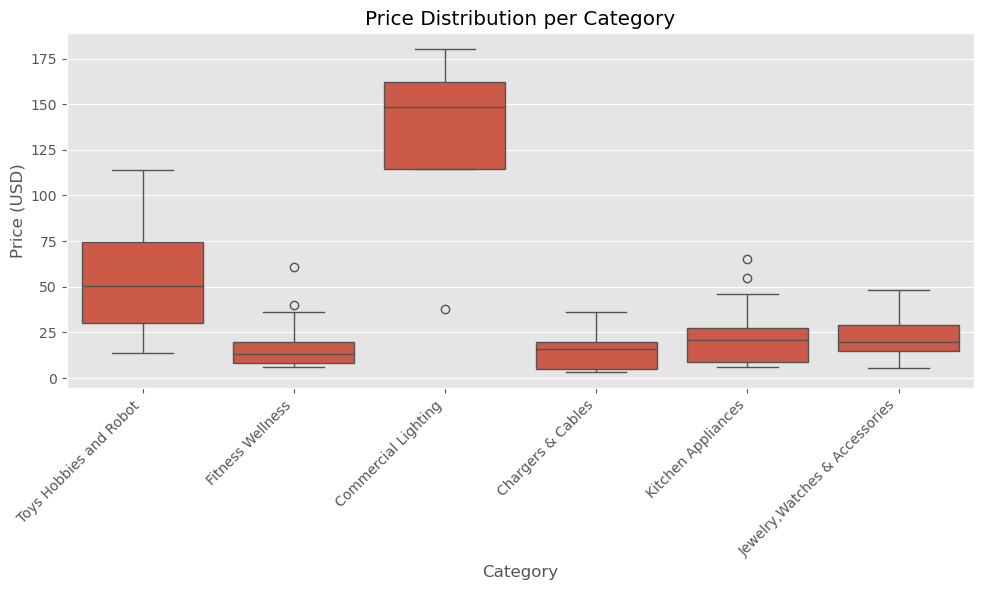

In [54]:
# Analysis 1 – Price distribution per category

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="category_name", y="PRICE_USD")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Category")
plt.ylabel("Price (USD)")
plt.title("Price Distribution per Category")
plt.tight_layout()
plt.show()


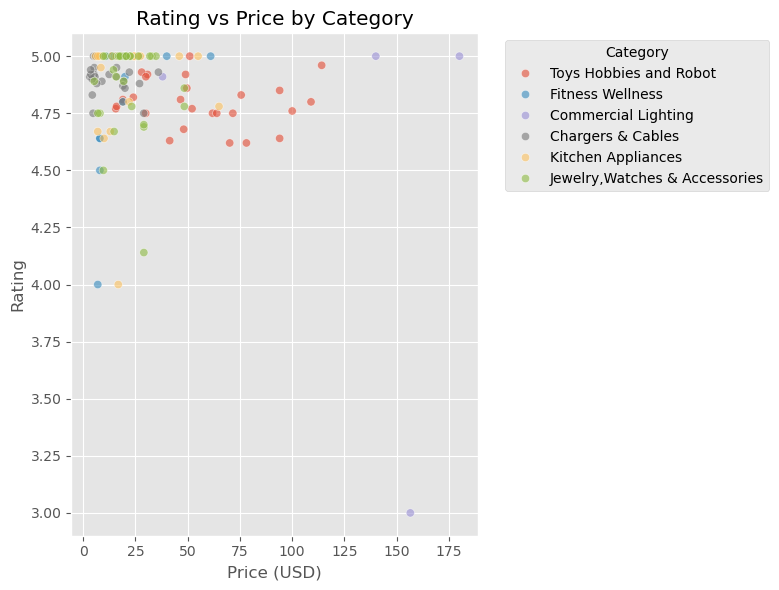

In [55]:
# Analysis 2 – Rating vs Price correlation

plt.figure(figsize=(8, 6))
subset = df.dropna(subset=["PRICE_USD", "rating"])
sns.scatterplot(data=subset, x="PRICE_USD", y="rating", hue="category_name", alpha=0.6)
plt.xlabel("Price (USD)")
plt.ylabel("Rating")
plt.title("Rating vs Price by Category")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [61]:
# quantify correlation:

corr = subset[["PRICE_USD", "rating"]].corr().iloc[0,1]
print("Correlation between price and rating:", round(corr, 3))


Correlation between price and rating: -0.269


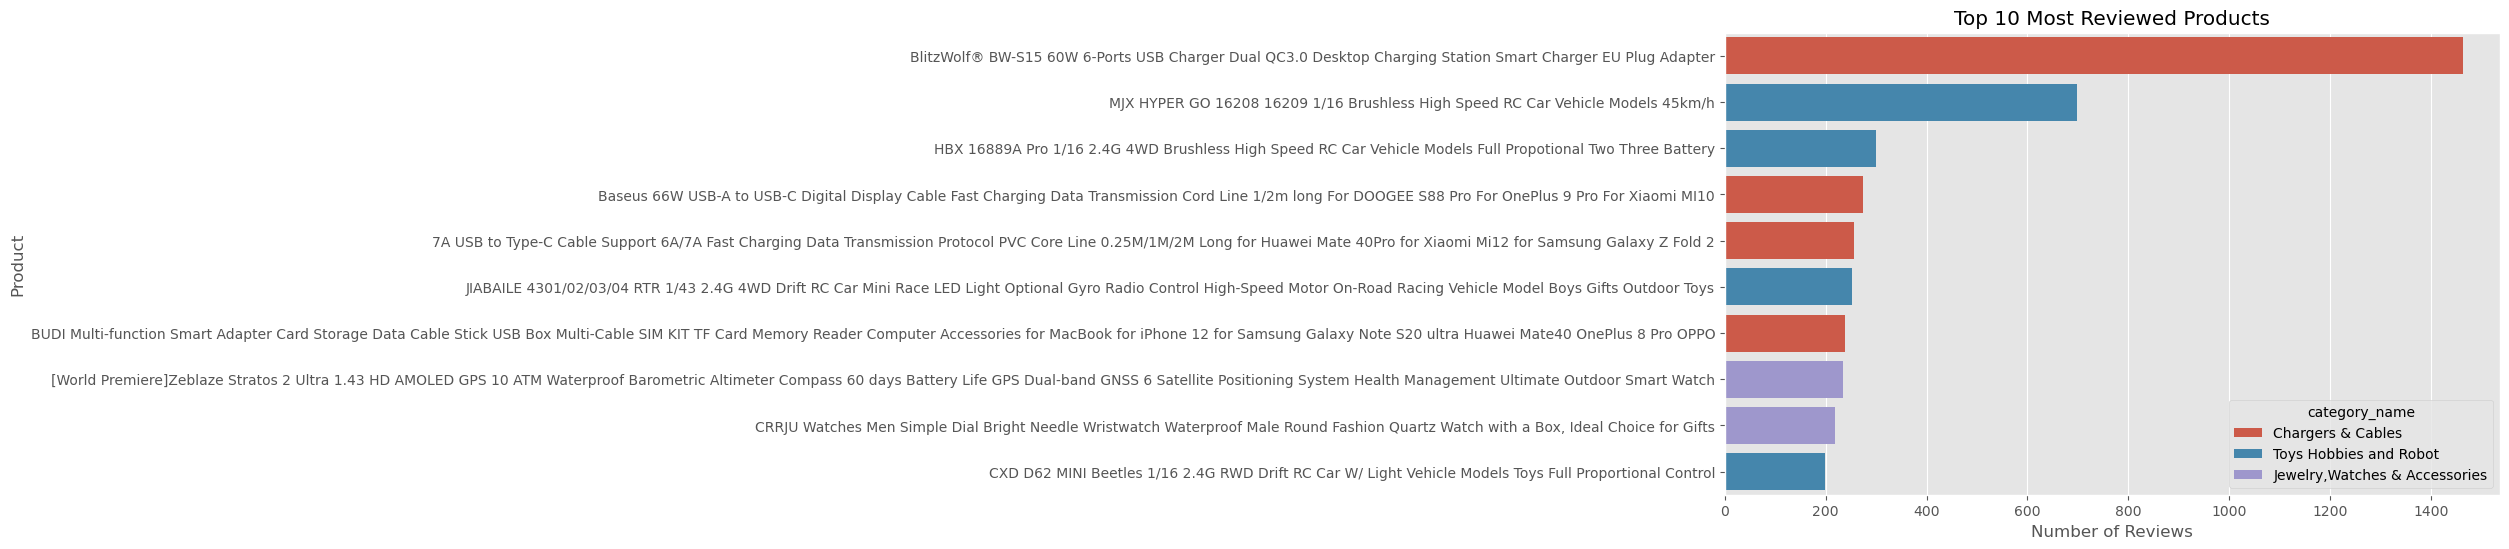

,category_name,product_name,reviews_count,PRICE_USD,rating
68,Chargers & Cables,BlitzWolf® BW-S15 60W 6-Ports USB Charger Dual...,1464,15.990,4.95
2,Toys Hobbies and Robot,MJX HYPER GO 16208 16209 1/16 Brushless High S...,698,93.990,4.85
26,Toys Hobbies and Robot,HBX 16889A Pro 1/16 2.4G 4WD Brushless High Sp...,300,108.990,4.80
74,Chargers & Cables,Baseus 66W USB-A to USB-C Digital Display Cabl...,273,8.950,4.89
65,Chargers & Cables,7A USB to Type-C Cable Support 6A/7A Fast Char...,257,3.160,4.91
0,Toys Hobbies and Robot,JIABAILE 4301/02/03/04 RTR 1/43 2.4G 4WD Drift...,253,23.990,4.82
73,Chargers & Cables,BUDI Multi-function Smart Adapter Card Storage...,239,12.430,4.92
126,"Jewelry,Watches & Accessories",[World Premiere]Zeblaze Stratos 2 Ultra 1.43 H...,235,48.375,4.86
134,"Jewelry,Watches & Accessories",CRRJU Watches Men Simple Dial Bright Needle Wr...,219,14.500,4.94
16,Toys Hobbies and Robot,CXD D62 MINI Beetles 1/16 2.4G RWD Drift RC Ca...,199,29.990,4.91


In [57]:
# TOP 10 Most Review Products

top_reviewed = (
    df.dropna(subset=["reviews_count"])
      .sort_values("reviews_count", ascending=False)
      .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_reviewed,
    x="reviews_count",
    y="product_name",
    hue="category_name",
    dodge=False
)
plt.xlabel("Number of Reviews")
plt.ylabel("Product")
plt.title("Top 10 Most Reviewed Products")
#plt.tight_layout()
plt.show()

top_reviewed[["category_name", "product_name", "reviews_count", "PRICE_USD", "rating"]]


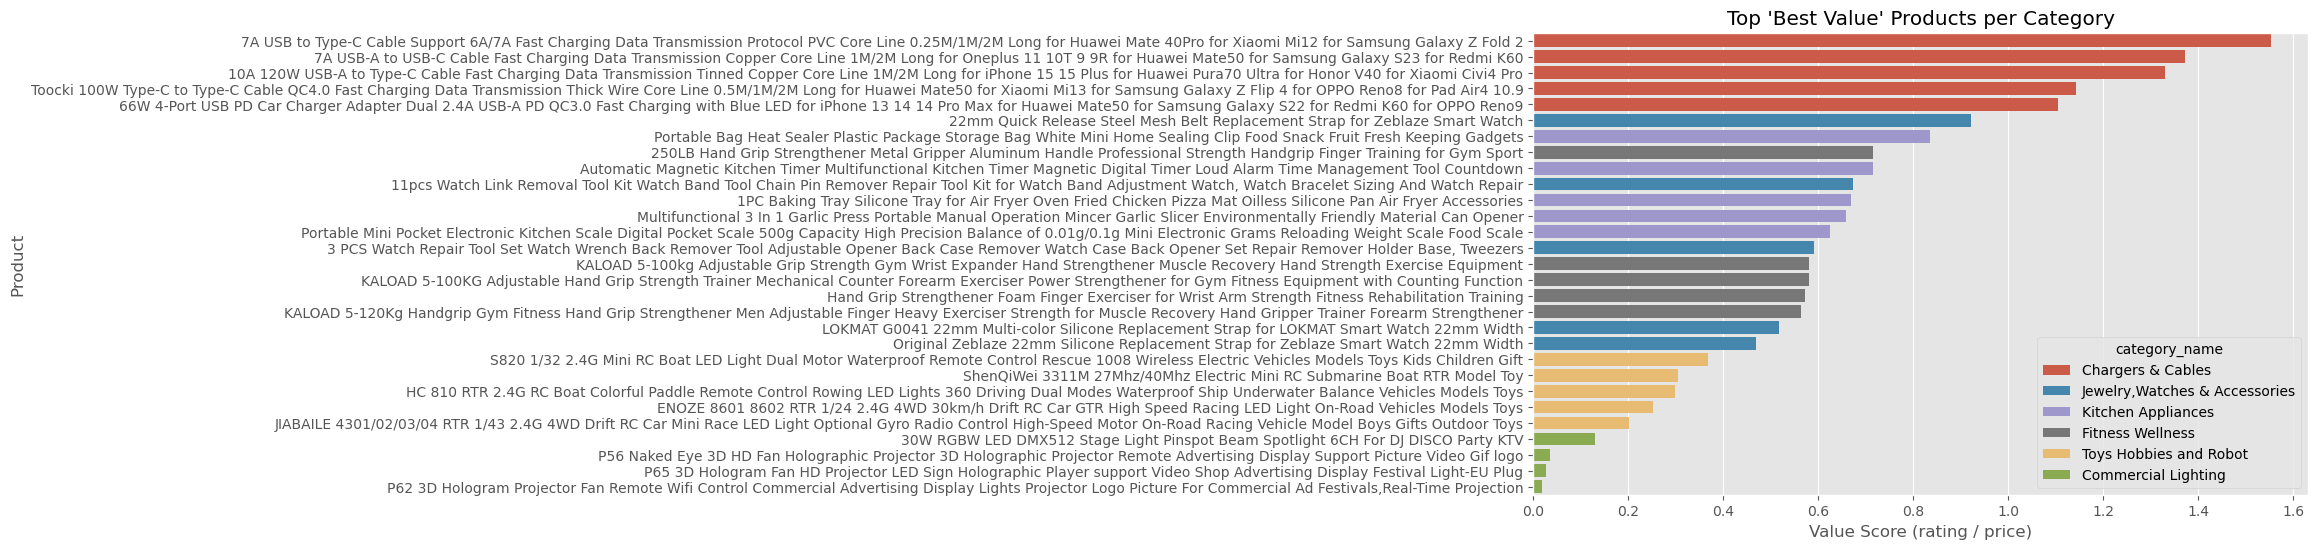

,category_name,product_name,PRICE_USD,rating,value_score
65,Chargers & Cables,7A USB to Type-C Cable Support 6A/7A Fast Char...,3.16,4.91,1.553797
92,Chargers & Cables,7A USB-A to USB-C Cable Fast Charging Data Tra...,3.60,4.94,1.372222
88,Chargers & Cables,10A 120W USB-A to Type-C Cable Fast Charging D...,3.70,4.92,1.329730
84,Chargers & Cables,Toocki 100W Type-C to Type-C Cable QC4.0 Fast ...,4.29,4.90,1.142191
83,Chargers & Cables,66W 4-Port USB PD Car Charger Adapter Dual 2.4...,4.37,4.83,1.105263
135,"Jewelry,Watches & Accessories",22mm Quick Release Steel Mesh Belt Replacement...,5.31,4.89,0.920904
111,Kitchen Appliances,Portable Bag Heat Sealer Plastic Package Stora...,5.99,5.00,0.834725
51,Fitness Wellness,250LB Hand Grip Strengthener Metal Gripper Alu...,6.99,5.00,0.715308
118,Kitchen Appliances,Automatic Magnetic Kitchen Timer Multifunction...,6.99,5.00,0.715308
133,"Jewelry,Watches & Accessories",11pcs Watch Link Removal Tool Kit Watch Band T...,7.05,4.75,0.673759


In [38]:
# Best Value For Money

value_df = df.dropna(subset=["value_score", "PRICE_USD", "rating"])

top_value = (
    value_df
    .sort_values("value_score", ascending=False)
    .groupby("category_name")
    .head(5)  
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_value,
    x="value_score",
    y="product_name",
    hue="category_name",
    dodge=False
)
plt.xlabel("Value Score (rating / price)")
plt.ylabel("Product")
plt.title("Top 'Best Value' Products per Category")
#plt.tight_layout()
plt.show()

top_value[["category_name", "product_name", "PRICE_USD", "rating", "value_score"]]


In [58]:
# Analysis 5 – Category-level popularity vs average price

cat_stats = (
    df.groupby("category_name")
      .agg(
          avg_price=("PRICE_USD", "mean"),
          avg_rating=("rating", "mean"),
          total_reviews=("reviews_count", "sum"),
          product_count=("product_name", "count")
      )
      .reset_index()
)

cat_stats


,category_name,avg_price,avg_rating,total_reviews,product_count
0,Chargers & Cables,14.366667,4.913448,3474,30
1,Commercial Lighting,128.615000,4.477500,68,4
2,Fitness Wellness,17.156667,4.832667,142,30
3,"Jewelry,Watches & Accessories",21.899167,4.870690,949,30
4,Kitchen Appliances,21.547000,4.875500,230,30
5,Toys Hobbies and Robot,55.524333,4.803333,3121,30


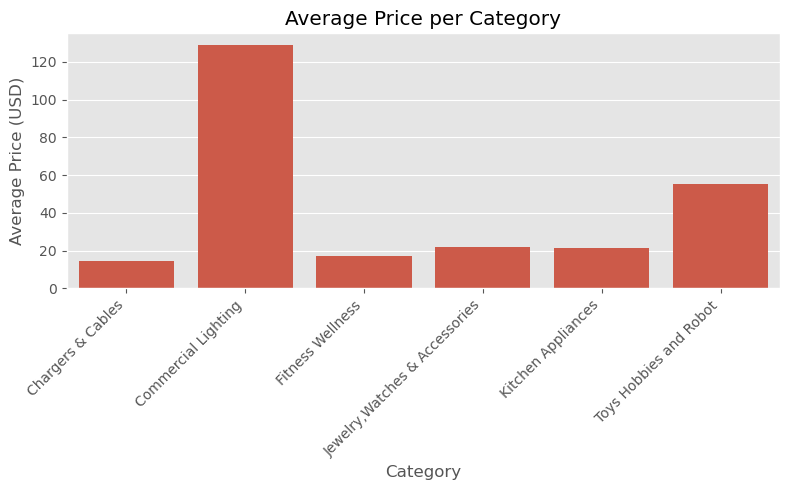

In [59]:
# Avg price per category

plt.figure(figsize=(8, 5))
sns.barplot(data=cat_stats, x="category_name", y="avg_price")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Category")
plt.ylabel("Average Price (USD)")
plt.title("Average Price per Category")
plt.tight_layout()
plt.show()


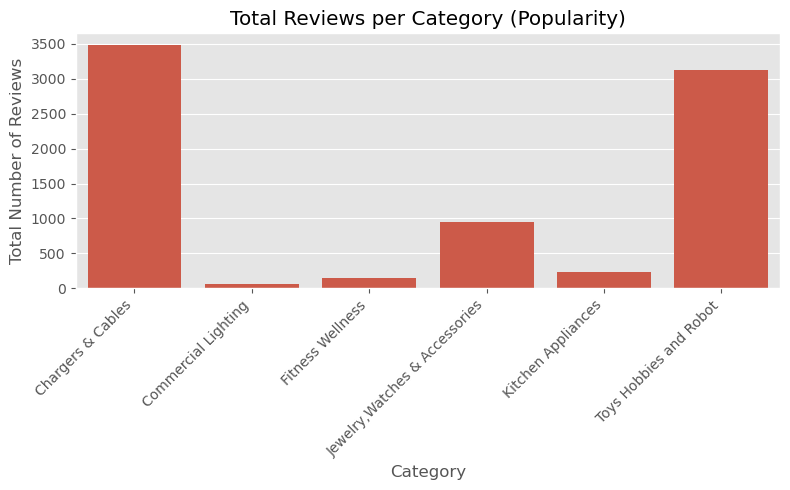

In [60]:
# Total reviews per category

plt.figure(figsize=(8, 5))
sns.barplot(data=cat_stats, x="category_name", y="total_reviews")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Category")
plt.ylabel("Total Number of Reviews")
plt.title("Total Reviews per Category (Popularity)")
plt.tight_layout()
plt.show()


In [69]:
pip install pyodbc

Note: you may need to restart the kernel to use updated packages.


In [74]:
import pyodbc
import pandas as pd
import numpy as np

# 1) Load the cleaned data you created earlier
df = pd.read_csv("banggood_cleaned_with_usd.csv")

import pyodbc

# If your instance is SQLEXPRESS, change SERVER to 'localhost\\SQLEXPRESS'
conn = pyodbc.connect(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=localhost;"           # or localhost\\SQLEXPRESS
    "Trusted_Connection=yes;"
)

cursor = conn.cursor()
print("Connected to SQL Server (server-level)!")





Connected to SQL Server (server-level)!


In [76]:
import pyodbc

conn = pyodbc.connect(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=localhost;"    # or localhost\\SQLEXPRESS
    "Trusted_Connection=yes;",
    autocommit=True
)

cursor = conn.cursor()
print("Connected with autocommit=True")


Connected with autocommit=True


In [77]:
cursor.execute("""
IF DB_ID('BanggoodDB') IS NULL
    CREATE DATABASE BanggoodDB;
""")

print("Database BanggoodDB is ready.")


Database BanggoodDB is ready.


In [79]:
import pyodbc

# 1) Connect to the server (no DB yet), with autocommit enabled
conn = pyodbc.connect(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=localhost;"           # or 'localhost\\SQLEXPRESS' if you're using SQLEXPRESS
    "Trusted_Connection=yes;",
    autocommit=True
)

cursor = conn.cursor()

cursor.execute("""
IF DB_ID('BanggoodDB') IS NULL
    CREATE DATABASE BanggoodDB;
""")

print("Ensured database BanggoodDB exists.")

cursor.close()
conn.close()


Ensured database BanggoodDB exists.


In [80]:
conn = pyodbc.connect(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=localhost;"           # or localhost\\SQLEXPRESS
    "DATABASE=BanggoodDB;"
    "Trusted_Connection=yes;"
)

cursor = conn.cursor()
print("Connected to BanggoodDB!")


Connected to BanggoodDB!


In [81]:
create_table_sql = """
IF OBJECT_ID('dbo.BanggoodProducts', 'U') IS NOT NULL
    DROP TABLE dbo.BanggoodProducts;

CREATE TABLE dbo.BanggoodProducts (
    id INT IDENTITY(1,1) PRIMARY KEY,
    category_name VARCHAR(255),
    category_url VARCHAR(500),
    product_name VARCHAR(MAX),
    price_raw VARCHAR(50),
    PRICE_USD FLOAT,
    rating_raw VARCHAR(50),
    rating FLOAT,
    reviews_raw VARCHAR(50),
    reviews_count INT,
    product_url VARCHAR(500),
    currency VARCHAR(20),
    converted_from_foreign BIT
);
"""

cursor.execute(create_table_sql)
conn.commit()
print("Table BanggoodProducts created successfully.")


Table BanggoodProducts created successfully.


In [82]:
cursor.execute("SELECT COUNT(*) FROM dbo.BanggoodProducts;")
print("Total rows:", cursor.fetchone()[0])

Total rows: 0


In [83]:
df.shape
df.head()


,category_name,category_url,product_name,price_raw,rating_raw,reviews_raw,product_url,price,reviews_count,rating,value_score,PRICE_USD,popularity_score
0,Toys Hobbies and Robot,https://www.banggood.com/Wholesale-RC-Vehicles...,JIABAILE 4301/02/03/04 RTR 1/43 2.4G 4WD Drift...,US$23.99,4.82,253 reviews,https://www.banggood.com/JIABAILE-4301-or-02-o...,23.99,253,4.82,0.200917,23.99,1219.46
1,Toys Hobbies and Robot,https://www.banggood.com/Wholesale-RC-Vehicles...,JJRC C8812 RTR 2.4G RC Car Tank High Speed Dri...,US$48.99,4.92,88 reviews,https://www.banggood.com/JJRC-C8812-RTR-2_4G-R...,48.99,88,4.92,0.100429,48.99,432.96
2,Toys Hobbies and Robot,https://www.banggood.com/Wholesale-RC-Vehicles...,MJX HYPER GO 16208 16209 1/16 Brushless High S...,US$93.99,4.85,698 reviews,https://www.banggood.com/MJX-HYPER-GO-16208-16...,93.99,698,4.85,0.051601,93.99,3385.30
3,Toys Hobbies and Robot,https://www.banggood.com/Wholesale-RC-Vehicles...,THE LINK G2067 RTR 1/16 2.4G RC Car Tank High ...,US$50.99,5.00,9 reviews,https://www.banggood.com/THE-LINK-G2067-RTR-1-...,50.99,9,5.00,0.098058,50.99,45.00
4,Toys Hobbies and Robot,https://www.banggood.com/Wholesale-RC-Vehicles...,SG PINECONE FOREST SG686 2.4G 1/72 Rc Boat Pow...,US$30.79,4.92,53 reviews,https://www.banggood.com/SG-PINECONE-FOREST-SG...,30.79,53,4.92,0.159792,30.79,260.76


In [85]:
print("DF SHAPE:", df.shape)
print("DF COLUMNS:", df.columns.tolist())
print(df.head(3))


DF SHAPE: (154, 13)
DF COLUMNS: ['category_name', 'category_url', 'product_name', 'price_raw', 'rating_raw', 'reviews_raw', 'product_url', 'price', 'reviews_count', 'rating', 'value_score', 'PRICE_USD', 'popularity_score']
            category_name                                       category_url  \
0  Toys Hobbies and Robot  https://www.banggood.com/Wholesale-RC-Vehicles...   
1  Toys Hobbies and Robot  https://www.banggood.com/Wholesale-RC-Vehicles...   
2  Toys Hobbies and Robot  https://www.banggood.com/Wholesale-RC-Vehicles...   

                                        product_name price_raw  rating_raw  \
0  JIABAILE 4301/02/03/04 RTR 1/43 2.4G 4WD Drift...  US$23.99        4.82   
1  JJRC C8812 RTR 2.4G RC Car Tank High Speed Dri...  US$48.99        4.92   
2  MJX HYPER GO 16208 16209 1/16 Brushless High S...  US$93.99        4.85   

   reviews_raw                                        product_url  price  \
0  253 reviews  https://www.banggood.com/JIABAILE-4301-or-02-o...  

In [103]:
import numpy as np
import pandas as pd
import re

# Clean reviews_count so all bad values become None
def safe_reviews_count(val):
    if pd.isna(val):
        return None
    val = str(val).strip()
    m = re.search(r"\d+", val)
    if not m:
        return None
    try:
        return int(m.group(0))
    except:
        return None

# Clean rating
def safe_rating(val):
    try:
        return float(val)
    except:
        return None

# Clean PRICE_USD
def safe_price(val):
    try:
        return float(val)
    except:
        return None

df["reviews_count"] = df["reviews_count"].apply(safe_reviews_count)
df["rating"]        = df["rating"].apply(safe_rating)
df["PRICE_USD"]     = df["PRICE_USD"].apply(safe_price)


In [104]:
rows_inserted = 0
errors = 0
failed_rows = []

for i, row in df.iterrows():
    try:
        # CLEAN STRING FIELDS (remove apostrophes to avoid SQL injection issues)
        product_name  = str(row.get("product_name")).replace("'", "")
        category_name = str(row.get("category_name")).replace("'", "")
        category_url  = str(row.get("category_url")).replace("'", "")
        price_raw     = str(row.get("price_raw")).replace("'", "")
        rating_raw    = str(row.get("rating_raw")).replace("'", "")
        reviews_raw   = str(row.get("reviews_raw")).replace("'", "")
        product_url   = str(row.get("product_url")).replace("'", "")
        currency      = str(row.get("currency")).replace("'", "")

        # NUMERIC SAFE CASTS
        price_usd = row.get("PRICE_USD")
        if pd.isna(price_usd):
            price_usd = None

        rating_val = row.get("rating")
        if pd.isna(rating_val):
            rating_val = None

        reviews_count_val = row.get("reviews_count")
        if pd.isna(reviews_count_val):
            reviews_count_val = None

        # FINAL INSERT
        cursor.execute(insert_sql,
            category_name,
            category_url,
            product_name,
            price_raw,
            price_usd,
            rating_raw,
            rating_val,
            reviews_raw,
            reviews_count_val,
            product_url,
            currency,
            1 if row.get("converted_from_foreign") else 0
        )

        rows_inserted += 1

    except Exception as e:
        errors += 1
        failed_rows.append((i, str(e)))
        print(f"❌ Error inserting row {i}: {e}")

conn.commit()
print("✅ FINAL INSERT REPORT")
print("Inserted:", rows_inserted)
print("Errors:", errors)


✅ FINAL INSERT REPORT
Inserted: 154
Errors: 0
